In [1]:
#import libary
import pandas as pd
import numpy as np
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ztress","key":"3daaa3eb054cbb63a7042360d18018bd"}'}

# Data Loading

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 1.27GB/s]


In [4]:
!unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [15]:
anime = pd.read_csv('anime.csv')
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [16]:
rating = pd.read_csv('rating.csv')
rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [17]:
print("Baris data anime\t: ", anime.shape[0])
print("Kolom data anime\t: ", anime.shape[1], "\n")
print("Baris data user rating\t: ", rating.shape[0])
print("Kolom data user rating\t: ", rating.shape[1])

Baris data anime	:  12294
Kolom data anime	:  7 

Baris data user rating	:  7813737
Kolom data user rating	:  3


Pada data anime terdapat :
- Baris	:  12.294
- Kolom	:  7

Pada data rating terdapat :
- Baris	:  7.813.737
- Kolom	:  3

In [18]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [19]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [20]:
anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [21]:
anime = anime.dropna(subset=['genre'])

In [22]:
anime.duplicated().sum()

np.int64(0)

In [23]:
rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


In [24]:
rating.duplicated().sum()

np.int64(1)

In [25]:
rating = rating.drop_duplicates()

In [26]:
all_genres = ','.join(anime['genre'].astype(str))

genre_list = all_genres.split(',')

unique_genres = sorted(set([g.strip() for g in genre_list]))

print(unique_genres)
print("Banyak genre : ", len(unique_genres))

['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri']
Banyak genre :  43


pada data anime memiliki 43 jenis genre yang berbeda

In [13]:
anime['genre'] = anime['genre'].apply(lambda x: ' '.join(x) if isinstance(x, list) else (x.replace(',', ' ') if isinstance(x, str) else str(x)))

<ipython-input-13-da8db724636d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime['genre'] = anime['genre'].apply(lambda x: ' '.join(x) if isinstance(x, list) else (x.replace(',', ' ') if isinstance(x, str) else str(x)))


hapus tanda "," pada anime yang memiliki genre lebih dari 1

untuk memastikan representasi fitur genre yang benar saat menggunakan teknik Content-Based Filtering berbasis TF-IDF.

In [14]:
all_anime_rate = rating
all_anime_rate

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


buat salinan data rating bernapa all_anime_rate

In [15]:
all_anime = pd.merge(all_anime_rate, anime[['anime_id','name','genre']], on='anime_id', how='left')

all_anime

,user_id,anime_id,rating,name,genre
0,1,20,-1,Naruto,Action Comedy Martial Arts Shounen Super P...
1,1,24,-1,School Rumble,Comedy Romance School Shounen
2,1,79,-1,Shuffle!,Comedy Drama Ecchi Fantasy Harem Magic R...
3,1,226,-1,Elfen Lied,Action Drama Horror Psychological Romance ...
4,1,241,-1,Girls Bravo: First Season,Comedy Ecchi Fantasy Harem Romance School
...,...,...,...,...,...
7813732,73515,16512,7,Devil Survivor 2 The Animation,Action Demons Supernatural
7813733,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,Mecha Police Psychological Sci-Fi
7813734,73515,22145,10,Kuroshitsuji: Book of Circus,Comedy Demons Fantasy Historical Shounen ...
7813735,73516,790,9,Ergo Proxy,Mystery Psychological Sci-Fi


mengambil data `name` dan `genre` dari data anime dan digabungkan menggunakan `anime_id`

In [16]:
all_anime["user_id"].value_counts()

,count
user_id,
48766,10227
42635,3747
53698,2905
57620,2702
59643,2633
...,...
9498,1
46794,1
46797,1


mengecek seberapa banyak user melakukan rating. <br>
menemukan data dengan `user_id` = "48766" memiliki 10.227 rating

In [17]:
all_anime[all_anime['user_id'] == 48766]["rating"].value_counts()

,count
rating,
-1,10227


menemukan data dengan `user_id` = "48766" merating -1 semua. <br>

terdapat keanehan mengapa user tersebut merating 10.227 data -1 semua.

In [18]:
all_anime = all_anime[all_anime['user_id'] != 48766]

karena tidak masuk akal, user tersebut akan dihapus

In [19]:
all_anime.isnull().sum()

,0
user_id,0
anime_id,0
rating,0
name,118
genre,118


terdapat data kosong pada kolom `nama` dan `genre`

In [20]:
all_anime_clean = all_anime.dropna()
all_anime_clean

,user_id,anime_id,rating,name,genre
0,1,20,-1,Naruto,Action Comedy Martial Arts Shounen Super P...
1,1,24,-1,School Rumble,Comedy Romance School Shounen
2,1,79,-1,Shuffle!,Comedy Drama Ecchi Fantasy Harem Magic R...
3,1,226,-1,Elfen Lied,Action Drama Horror Psychological Romance ...
4,1,241,-1,Girls Bravo: First Season,Comedy Ecchi Fantasy Harem Romance School
...,...,...,...,...,...
7813732,73515,16512,7,Devil Survivor 2 The Animation,Action Demons Supernatural
7813733,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,Mecha Police Psychological Sci-Fi
7813734,73515,22145,10,Kuroshitsuji: Book of Circus,Comedy Demons Fantasy Historical Shounen ...
7813735,73516,790,9,Ergo Proxy,Mystery Psychological Sci-Fi


karena tidak dapat diidentifikasi `nama` serta `genre`nya, maka diputuskan untuk menghapus data yang hilang tersebut

In [21]:
fix_anime = all_anime_clean.sort_values('anime_id', ascending=True)
fix_anime

,user_id,anime_id,rating,name,genre
6279388,58506,1,-1,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
4238969,40172,1,-1,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
2771520,26041,1,6,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
2616895,24742,1,8,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
6031658,56597,1,10,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
...,...,...,...,...,...
7703451,72404,34412,-1,Hashiri Hajimeta bakari no Kimi ni,Music
5704639,53492,34475,5,Monster Strike: Rain of Memories,Action Fantasy Game
7535009,70547,34475,9,Monster Strike: Rain of Memories,Action Fantasy Game
7558121,70768,34475,-1,Monster Strike: Rain of Memories,Action Fantasy Game


In [22]:
len(fix_anime.anime_id.unique())

10152

In [23]:
preparation = fix_anime
preparation.sort_values('anime_id')

,user_id,anime_id,rating,name,genre
703510,6624,1,-1,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
4280181,40528,1,8,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
374994,3839,1,9,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
4322742,40853,1,-1,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
1036224,9931,1,9,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
...,...,...,...,...,...
7703451,72404,34412,-1,Hashiri Hajimeta bakari no Kimi ni,Music
7558121,70768,34475,-1,Monster Strike: Rain of Memories,Action Fantasy Game
7535009,70547,34475,9,Monster Strike: Rain of Memories,Action Fantasy Game
5704639,53492,34475,5,Monster Strike: Rain of Memories,Action Fantasy Game


In [24]:
preparation = preparation.drop_duplicates('anime_id')
preparation

,user_id,anime_id,rating,name,genre
6279388,58506,1,-1,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
869517,7932,5,9,Cowboy Bebop: Tengoku no Tobira,Action Drama Mystery Sci-Fi Space
5789396,54166,6,9,Trigun,Action Comedy Sci-Fi
1652404,16054,7,-1,Witch Hunter Robin,Action Drama Magic Mystery Police Superna...
5641308,52966,8,10,Beet the Vandel Buster,Adventure Fantasy Shounen Supernatural
...,...,...,...,...,...
7645790,71792,34325,8,Pokemon XY&amp;Z Specials,Action Adventure Comedy Fantasy Kids
1282901,12145,34349,-1,Diamond no Ace: Second Season OVA,Comedy School Shounen Sports
6452110,59643,34367,5,Long Riders Recap,Comedy Shounen Slice of Life Sports
7703451,72404,34412,-1,Hashiri Hajimeta bakari no Kimi ni,Music


Menghapus data `anime_id` yang duplikat agar data ini bisa digunakan untuk pemodelan

In [25]:
anime_id = preparation['anime_id'].tolist()

anime_name = preparation['name'].tolist()

anime_genre = preparation['genre'].tolist()

print(len(anime_id))
print(len(anime_name))
print(len(anime_genre))

10152
10152
10152


konversi data menjadi list

In [26]:
anime_new = pd.DataFrame({
    'id': anime_id,
    'anime_name': anime_name,
    'genre': anime_genre
})
anime_new

,id,anime_name,genre
0,1,Cowboy Bebop,Action Adventure Comedy Drama Sci-Fi Space
1,5,Cowboy Bebop: Tengoku no Tobira,Action Drama Mystery Sci-Fi Space
2,6,Trigun,Action Comedy Sci-Fi
3,7,Witch Hunter Robin,Action Drama Magic Mystery Police Superna...
4,8,Beet the Vandel Buster,Adventure Fantasy Shounen Supernatural
...,...,...,...
10147,34325,Pokemon XY&amp;Z Specials,Action Adventure Comedy Fantasy Kids
10148,34349,Diamond no Ace: Second Season OVA,Comedy School Shounen Sports
10149,34367,Long Riders Recap,Comedy Shounen Slice of Life Sports
10150,34412,Hashiri Hajimeta bakari no Kimi ni,Music


membuat dictionary untuk menentukan pasangan key-value pada data anime_id, anime_name, dan genre yang telah disiapkan

# Modeling

## Content Based Filtering

In [27]:
data = anime_new
data.sample(5)

,id,anime_name,genre
4700,6797,Docchi ni Suru?,Kids
9745,32240,Code Geass: Boukoku no Akito 4 - Nikushimi no ...,Comedy Ecchi Military
8580,26009,His Lipstick,Comedy Kids
303,329,Planetes,Drama Romance Sci-Fi Seinen Space
4627,6636,Chou Kousoku Galvion,Action Mecha Military Police


assign dataframe yang sudah dibuat sebelumnya ke dalam variabel data

In [28]:
tf = TfidfVectorizer()

tf.fit(data['genre'])

tf.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire', 'yaoi', 'yuri'],
      dtype=object)

menemukan representasi fitur penting dari setiap genre anime.

In [29]:
tfidf_matrix = tf.fit_transform(data['genre'])

tfidf_matrix.shape

(10152, 47)

fit dan transformasi ke dalam bentuk matriks

In [30]:
tfidf_matrix.todense()

matrix([[0.3129524 , 0.3440427 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.2976287 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.48729691, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.37846493, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()

In [32]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.anime_name
).sample(22, axis=1).sample(10, axis=0)

,yaoi,music,police,military,thriller,slice,school,josei,cars,vampire,...,parody,space,magic,dementia,demons,hentai,kids,drama,romance,power
anime_name,,,,,,,,,,,,,,,,,,,,,
Makeruna! Makendou,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.729995,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
Onikirimaru,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.515679,0.000000,0.0,0.0,0.000000,0.0
Spocon!,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0
Eat You Up/Bunny,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
Dragon Knight Gaiden,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.693405,0.483455,0.0,0.0,0.000000,0.0
Seichou Rap,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
Ai wa Kagi no Kazu dake... Fuuzoku Mansion,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0
Hikari no Densetsu,0.0,0.493803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.407129,0.0
LolitA☆Strawberry in Summer,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


lihat matriks tf-idf untuk beberapa anime (anime_name) dan genre anime (genre)

Output matriks tf-idf di atas menunjukkan Anime Eat You Up/Bunny memiliki genre yaoi dan beberaoa anime menunjuk genrenya.

In [34]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.77533768, 0.6422212 , ..., 0.06404684, 0.        ,
        0.11844151],
       [0.77533768, 1.        , 0.51247894, ..., 0.        , 0.        ,
        0.11264202],
       [0.6422212 , 0.51247894, 1.        , ..., 0.09972708, 0.        ,
        0.18442479],
       ...,
       [0.06404684, 0.        , 0.09972708, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.11844151, 0.11264202, 0.18442479, ..., 0.        , 0.        ,
        1.        ]])

 menghitung derajat kesamaan (similarity degree) antar restoran dengan teknik cosine similarity.

In [40]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['anime_name'], columns=data['name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (10152, 10152)


anime_name,Ikusa Otome Valkyrie Shinshou,Kyuukyoku no Chef wa Oishinbo Papa,Wonder,Words Worth,Crayon Shin-chan Movie 10: Arashi wo Yobu Appare! Sengoku Daikassen
anime_name,,,,,
Fault!!,1.000000,1.000000,0.000000,0.419187,0.000000
Kyuuketsuki,0.496478,0.496478,0.000000,0.208118,0.000000
Ristorante Paradiso,0.000000,0.000000,0.000000,0.000000,0.209553
Memory,0.000000,0.000000,0.000000,0.000000,0.000000
Strike Witches 2,0.000000,0.000000,0.000000,0.216776,0.000000
The iDOLM@STER Million Live! &quot;Dreaming!&quot; Animation PV,0.000000,0.000000,0.636949,0.000000,0.000000
Metal Fight Beyblade: Baku,0.000000,0.000000,0.000000,0.168216,0.000000
Bamboo Blade: Fanfu-Fufe-Fo,0.000000,0.000000,0.000000,0.000000,0.000000
Kyousou Giga (2012),0.000000,0.000000,0.000000,0.186875,0.000000


Melihat matriks kesamaan setiap anime dengan menampilkan nama anime dalam 5 sampel kolom dan 10 baris

In [42]:
def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=data[['anime_name', 'genre']], k=5):

    index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(nama_anime, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

membuat fungsi anime_recommendations dengan beberapa parameter sebagai berikut:

nama_anime : Nama anime (index kemiripan dataframe).
Similarity_data : Dataframe mengenai similarity yang telah kita definisikan sebelumnya.
Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah anime_name’ dan ‘genre.
k : Banyak rekomendasi yang ingin diberikan.

In [ ]:
anime[anime.name.eq('Naruto')]

,anime_id,name,genre,type,episodes,rating,members
841,20,Naruto,Action Comedy Martial Arts Shounen Super P...,TV,220,7.81,683297


In [56]:
anime_recommendations('One Punch Man')

,anime_name,genre
0,One Punch Man: Road to Hero,Action Comedy Parody Sci-Fi Seinen Super ...
1,One Punch Man Specials,Action Comedy Parody Sci-Fi Seinen Super ...
2,Tentai Senshi Sunred 2nd Season,Comedy Parody Seinen Super Power
3,Tentai Senshi Sunred: Short Corner,Comedy Parody Seinen Super Power
4,Tentai Senshi Sunred,Comedy Parody Seinen Super Power


mendapatkan anime recommendation dengan memanggil fungsi yang telah kita definisikan sebelumnya

# Collaboration Filtering

In [94]:
rating = rating.sample(n=10_000, random_state=42)

df = rating
df

,user_id,anime_id,rating,user,anime
7806172,73424,7785,10,73422,1067
6470262,59789,19769,6,59787,256
5975474,55960,59,10,55958,603
7617688,71461,3342,10,71459,1361
5932334,55390,986,8,55388,1408
...,...,...,...,...,...
5857725,54742,4918,-1,54740,1584
5130102,48995,4793,10,48993,3372
6563938,60621,21855,8,60619,1175
1506319,14513,20057,9,14512,544


In [95]:
print("banyak data : ", df.shape[0])

banyak data :  10000


Karena data sangat banyak sehingga sangat memakan waktu pelatihan, maka akan kami hapus random menjadi 10.000 data saja

In [96]:
user_ids = df['user_id'].unique().tolist()
print('list userID: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [73424, 59789, 55960, 71461, 55390, 21160, 51693, 57050, 35577, 4574, 38920, 38644, 66021, 36665, 61228, 47612, 10501, 3398, 43494, 56577, 52017, 57033, 48981, 28241, 35247, 44946, 44872, 46109, 48485, 21208, 29414, 16980, 497, 1843, 67934, 66792, 23529, 68139, 58736, 51999, 54001, 63710, 20928, 2431, 20081, 70961, 68130, 701, 22649, 10212, 36658, 57253, 72477, 36205, 55258, 37948, 58522, 27035, 12430, 45659, 61501, 46469, 26347, 48203, 27351, 22334, 11495, 35417, 61430, 49832, 46077, 2480, 72947, 32234, 51092, 62478, 57327, 21748, 32567, 35635, 58656, 41832, 45477, 19399, 39223, 61115, 49418, 55319, 32859, 27678, 33643, 53793, 31478, 65497, 45649, 72325, 63976, 20742, 43668, 51559, 60407, 43599, 35856, 66780, 24098, 33833, 24434, 7070, 6769, 3414, 23343, 38933, 24706, 55310, 63598, 896, 30595, 10931, 5011, 21510, 18355, 65005, 11097, 43529, 58785, 18193, 40611, 58180, 68568, 8706, 50685, 58219, 42148, 39009, 43308, 12344, 11740, 37703, 70967, 30680, 28198, 44175, 9083, 2

In [97]:
anime_ids = df['anime_id'].unique().tolist()

anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}

anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}

menyandikan (encode) fitur ‘user’ dan ‘anime_id’ ke dalam indeks integer.

In [98]:
df['user'] = df['user_id'].map(user_to_user_encoded)

df['anime'] = df['anime_id'].map(anime_to_anime_encoded)

petakan user_id dan anime_id ke dataframe yang berkaitan.

In [99]:
num_users = len(user_to_user_encoded)
print(num_users)

num_anime = len(anime_to_anime_encoded)
print(num_anime)

df['rating'] = df['rating'].values.astype(np.float32)

min_rating = min(df['rating'])

max_rating = max(df['rating'])

print('Number of User: {}, Number of Anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_anime, min_rating, max_rating
))

8441
2781
Number of User: 8441, Number of Anime: 2781, Min Rating: -1.0, Max Rating: 10.0


## Spliting Data untuk Training dan Validasi

In [100]:
df = df.sample(frac=1, random_state=42)
df

,user_id,anime_id,rating,user,anime
4124508,39176,30205,9.0,5610,216
1998931,19375,12549,6.0,4298,496
3851954,36099,15583,9.0,1680,498
1988875,19293,1726,-1.0,3537,946
4222093,40018,275,6.0,4154,1914
...,...,...,...,...,...
706725,6647,11499,5.0,5184,847
1220540,11527,2001,8.0,4737,45
688301,6513,243,-1.0,4908,1407
5749919,53852,11763,7.0,847,647


acak datanya terlebih dahulu agar distribusinya menjadi random.

In [101]:
x = df[['user', 'anime']].values

y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[5610  216]
 [4298  496]
 [1680  498]
 ...
 [4908 1407]
 [ 847  647]
 [6413  386]] [0.90909091 0.63636364 0.90909091 ... 0.         0.72727273 0.        ]


bagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, kita perlu memetakan (mapping) data user dan anime menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

## Training

In [102]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])

    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)

    x = dot_user_anime + user_bias + anime_bias

    return tf.nn.sigmoid(x)

Membuat model RecommendNet menggunakan keras

In [111]:
model = RecommenderNet(num_users, num_anime, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

melakukan proses compile terhadap model.



In [112]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6934 - root_mean_squared_error: 0.3713 - val_loss: 0.6928 - val_root_mean_squared_error: 0.3739
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6896 - root_mean_squared_error: 0.3696 - val_loss: 0.6920 - val_root_mean_squared_error: 0.3734
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6847 - root_mean_squared_error: 0.3638 - val_loss: 0.6913 - val_root_mean_squared_error: 0.3729
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6801 - root_mean_squared_error: 0.3630 - val_loss: 0.6906 - val_root_mean_squared_error: 0.3724
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6741 - root_mean_squared_error: 0.3604 - val_loss: 0.6899 - val_root_mean_squared_error: 0.3719
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6680 - root_mean_squared_error: 0.3540 - val_loss: 0.6893 - val_root_mean_squared_error: 0.3715
Epoch 7/100
1000/1000 ━━━━━━━━━━━━

Melakukan training

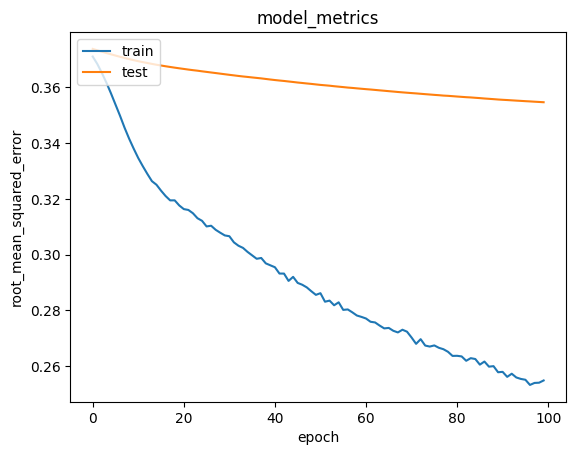

In [113]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model collaborative filtering yang digunakan menunjukkan kinerja yang baik karena berhasil menurunkan RMSE pada data training dan test secara konsisten. Grafik ini menjadi indikator bahwa proses pelatihan berjalan dengan benar dan model memiliki kemampuan generalisasi yang layak.

In [114]:
anime_df = anime_new
df = rating

user_id = df.user_id.sample(1).iloc[0]
anime_visited_by_user = df[df.user_id == user_id]

anime_not_visited = anime_df[~anime_df['id'].isin(anime_visited_by_user.anime_id.values)]['id']
anime_not_visited = list(
    set(anime_not_visited)
    .intersection(set(anime_to_anime_encoded.keys()))
)

anime_not_visited = [[anime_to_anime_encoded.get(x)] for x in anime_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_visited), anime_not_visited)
)

Mengambil sample

In [115]:
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('anime with high ratings from user')
print('----' * 8)

top_anime_user = (
    anime_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

anime_df_rows = anime_df[anime_df['id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.anime_name, ':', row.genre)

print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)

recommended_anime = anime_df[anime_df['id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.anime_name, ':', row.genre)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Showing recommendations for users: 59535
anime with high ratings from user
--------------------------------
Tenkuu no Shiro Laputa : Adventure  Fantasy  Romance  Sci-Fi
--------------------------------
Top 10 anime recommendation
--------------------------------
Great Teacher Onizuka : Comedy  Drama  School  Shounen  Slice of Life
Hotaru no Haka : Drama  Historical
Bakuman. : Comedy  Romance  Shounen
Bakuman. 2nd Season : Comedy  Drama  Romance  Shounen
Kill la Kill : Action  Comedy  School  Super Power
Haikyuu!! : Comedy  Drama  School  Shounen  Sports
Shigatsu wa Kimi no Uso : Drama  Music  Romance  School  Shounen
Ansatsu Kyoushitsu (TV) : Action  Comedy  School  Shounen
Haikyuu!! Second Season : Comedy  Drama  School  Shounen  Sports
Musaigen no Phantom World : Action  Comedy  Fantasy  Slice of Life  Supernatural


Mendapatkan hasil rekomendasi